In [36]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import matplotlib.pyplot as plt

fake = Faker()

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# ----------------------------
# 1. SUPPLIERS
# ----------------------------
num_suppliers = 20
suppliers = []

for i in range(1, num_suppliers + 1):
    suppliers.append({
        "supplier_id": i,
        "supplier_name": fake.company(),
        "country": fake.country(),
        "lead_time_days": np.random.randint(5, 30),
        "on_time_rate": round(np.random.uniform(0.7, 0.99), 2),
        "freight_cost": np.random.randint(200, 3000)
    })

df_suppliers = pd.DataFrame(suppliers)
df_suppliers.to_csv("suppliers.csv", index=False)


# ----------------------------
# 2. PRODUCTS
# ----------------------------
num_products = 80
products = []

for i in range(1, num_products + 1):
    products.append({
        "product_id": i,
        "product_name": fake.word().capitalize() + " " + fake.word().capitalize(),
        "category": random.choice(["Electronics", "Furniture", "Office Supplies", "Food", "Hardware"]),
        "unit_cost": round(np.random.uniform(2, 250), 2),
        "supplier_id": np.random.randint(1, num_suppliers + 1)
    })

df_products = pd.DataFrame(products)
df_products.to_csv("products.csv", index=False)


# ----------------------------
# 3. PURCHASE ORDERS
# ----------------------------
num_orders = 500
purchase_orders = []

for i in range(1, num_orders + 1):
    order_date = fake.date_between(start_date="-1y", end_date="today")
    qty = np.random.randint(10, 300)
    
    purchase_orders.append({
        "order_id": i,
        "product_id": np.random.randint(1, num_products + 1),
        "order_date": order_date,
        "quantity_ordered": qty,
        "total_cost": round(qty * np.random.uniform(5, 150), 2)
    })

df_po = pd.DataFrame(purchase_orders)
df_po.to_csv("purchase_orders.csv", index=False)

# ----------------------------
# 4. INVENTORY MOVEMENTS
# ----------------------------

num_products = 80
num_movements_per_product = 18
opening_stock = 500

inventory_movements = []
movement_id = 1

for product_id in range(1, num_products + 1):

    # 1️⃣ OPENING BALANCE
    start_date = fake.date_between(start_date="-1y", end_date="-11m")

    inventory_movements.append({
        "movement_id": movement_id,
        "product_id": product_id,
        "movement_type": "OPENING",
        "quantity": opening_stock,
        "movement_date": start_date
    })
    movement_id += 1

    current_stock = opening_stock

    # 2️⃣ FUTURE MOVEMENTS
    movement_dates = sorted(
        fake.date_between(start_date=start_date, end_date="today")
        for _ in range(num_movements_per_product)
    )

    for movement_date in movement_dates:

        movement_type = random.choice(["IN", "OUT"])

        if movement_type == "IN":
            qty = np.random.randint(20, 150)
            current_stock += qty

        else:  # OUT
            max_out = min(120, current_stock)
            if max_out <= 0:
                continue

            qty = np.random.randint(1, max_out + 1)
            current_stock -= qty

        inventory_movements.append({
            "movement_id": movement_id,
            "product_id": product_id,
            "movement_type": movement_type,
            "quantity": qty,
            "movement_date": movement_date
        })
        movement_id += 1

dfinv = pd.DataFrame(inventory_movements)
dfinv.to_csv("inventory_movements.csv", index=False)

# ----------------------------
# 5. DELIVERY TIMES
# ----------------------------

delivery_times = []

df_po_merged = df_po.merge(df_products[["product_id", "supplier_id"]], on="product_id", how="left")

for idx, row in df_po_merged.iterrows():
    supplier_id = row["supplier_id"]
    
    expected_lt = int(df_suppliers.loc[df_suppliers["supplier_id"] == supplier_id, "lead_time_days"].values[0])
    
    actual_lt = max(1, int(np.random.normal(expected_lt, 3)))
    
    delivery_date = pd.to_datetime(row["order_date"]) + pd.Timedelta(days=actual_lt)
    
    delivery_times.append({
        "order_id": row["order_id"],
        "product_id": row["product_id"],
        "supplier_id": supplier_id,
        "order_date": row["order_date"],
        "expected_lead_time_days": expected_lt,
        "actual_lead_time_days": actual_lt,
        "delay_days": actual_lt - expected_lt,
        "expected_delivery_date": pd.to_datetime(row["order_date"]) + pd.Timedelta(days=expected_lt),
        "actual_delivery_date": delivery_date
    })

df_deliveries = pd.DataFrame(delivery_times)
df_deliveries.to_csv("delivery_times.csv", index=False)

print("Synthetic supply-chain dataset created successfully!")

Synthetic supply-chain dataset created successfully!


In [37]:
dfdel = pd.read_csv('delivery_times.csv')
dfdel.describe()

,order_id,product_id,supplier_id,expected_lead_time_days,actual_lead_time_days,delay_days
count,500.000000,500.000000,500.00000,500.000000,500.00000,500.000000
mean,250.500000,38.740000,9.00600,18.420000,18.17600,-0.244000
std,144.481833,22.686157,5.86026,6.434781,7.18835,3.105439
min,1.000000,1.000000,1.00000,6.000000,1.00000,-9.000000
25%,125.750000,19.000000,4.00000,14.000000,13.00000,-2.000000
50%,250.500000,38.000000,8.00000,16.000000,18.00000,0.000000
75%,375.250000,58.000000,13.00000,25.000000,24.00000,2.000000
max,500.000000,80.000000,20.00000,29.000000,35.00000,9.000000


In [38]:
dfdel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   order_id                 500 non-null    int64 
 1   product_id               500 non-null    int64 
 2   supplier_id              500 non-null    int64 
 3   order_date               500 non-null    object
 4   expected_lead_time_days  500 non-null    int64 
 5   actual_lead_time_days    500 non-null    int64 
 6   delay_days               500 non-null    int64 
 7   expected_delivery_date   500 non-null    object
 8   actual_delivery_date     500 non-null    object
dtypes: int64(6), object(3)
memory usage: 35.3+ KB


In [39]:
# Create an 'on_time' column that tells whether the supplier is on time

dfdel['on_time'] = dfdel['delay_days'] >= 0

In [40]:
dfdel.head()

,order_id,product_id,supplier_id,order_date,expected_lead_time_days,actual_lead_time_days,delay_days,expected_delivery_date,actual_delivery_date,on_time
0,1,75,2,2025-06-02,15,21,6,2025-06-17,2025-06-23,True
1,2,25,10,2025-02-20,20,18,-2,2025-03-12,2025-03-10,False
2,3,54,2,2025-06-16,15,7,-8,2025-07-01,2025-06-23,False
3,4,33,2,2025-02-11,15,14,-1,2025-02-26,2025-02-25,False
4,5,48,2,2025-11-09,15,14,-1,2025-11-24,2025-11-23,False


In [41]:
dfinv = pd.read_csv('inventory_movements.csv')
dfinv.describe()

,movement_id,product_id,quantity
count,1517.000000,1517.000000,1517.000000
mean,759.000000,40.518787,93.986816
std,438.064493,23.118781,103.105013
min,1.000000,1.000000,1.000000
25%,380.000000,20.000000,40.000000
50%,759.000000,41.000000,72.000000
75%,1138.000000,61.000000,108.000000
max,1517.000000,80.000000,500.000000


In [42]:
dfinv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1517 entries, 0 to 1516
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   movement_id    1517 non-null   int64 
 1   product_id     1517 non-null   int64 
 2   movement_type  1517 non-null   object
 3   quantity       1517 non-null   int64 
 4   movement_date  1517 non-null   object
dtypes: int64(3), object(2)
memory usage: 59.4+ KB


In [43]:
# Convert column 'movement_date' to dtype datetime.

dfinv['movement_date'] = pd.to_datetime(dfinv['movement_date'])

In [44]:
dfinv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1517 entries, 0 to 1516
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   movement_id    1517 non-null   int64         
 1   product_id     1517 non-null   int64         
 2   movement_type  1517 non-null   object        
 3   quantity       1517 non-null   int64         
 4   movement_date  1517 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 59.4+ KB


In [70]:
dfinv["signed_qty"] = df_inv.apply(
    lambda x: x["quantity"]
    if x["movement_type"] in ["IN", "OPENING"]
    else -x["quantity"],
    axis=1
)

dfinv = dfinv.sort_values(["product_id", "movement_date"])

dfinv["running_stock"] = (
    dfinv.groupby("product_id")["signed_qty"].cumsum()
)

In [45]:
dfpo = pd.read_csv('purchase_orders.csv')
dfpo.describe()

,order_id,product_id,quantity_ordered,total_cost
count,500.000000,500.000000,500.00000,500.000000
mean,250.500000,38.740000,154.81600,12025.503280
std,144.481833,22.686157,85.99428,9861.619837
min,1.000000,1.000000,10.00000,131.330000
25%,125.750000,19.000000,81.75000,3644.662500
50%,250.500000,38.000000,154.50000,9860.125000
75%,375.250000,58.000000,233.25000,18053.407500
max,500.000000,80.000000,299.00000,43587.830000


In [46]:
dfpo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          500 non-null    int64  
 1   product_id        500 non-null    int64  
 2   order_date        500 non-null    object 
 3   quantity_ordered  500 non-null    int64  
 4   total_cost        500 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 19.7+ KB


In [47]:
# Convert column 'order_date' to dtype datetime.

dfpo['order_date'] = pd.to_datetime(dfpo['order_date'])

In [48]:
dfpo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_id          500 non-null    int64         
 1   product_id        500 non-null    int64         
 2   order_date        500 non-null    datetime64[ns]
 3   quantity_ordered  500 non-null    int64         
 4   total_cost        500 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 19.7 KB


In [49]:
dfpo.head()

,order_id,product_id,order_date,quantity_ordered,total_cost
0,1,75,2025-06-02,125,17583.38
1,2,25,2025-02-20,113,647.93
2,3,54,2025-06-16,203,14214.36
3,4,33,2025-02-11,178,1356.53
4,5,48,2025-11-09,286,32387.00


In [50]:
dfprod = pd.read_csv('products.csv')
dfprod.describe()

,product_id,unit_cost,supplier_id
count,80.0000,80.000000,80.000000
mean,40.5000,122.090875,9.100000
std,23.2379,68.220771,5.729338
min,1.0000,3.720000,1.000000
25%,20.7500,65.720000,4.000000
50%,40.5000,113.090000,8.500000
75%,60.2500,179.490000,13.000000
max,80.0000,249.070000,20.000000


In [51]:
dfprod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_id    80 non-null     int64  
 1   product_name  80 non-null     object 
 2   category      80 non-null     object 
 3   unit_cost     80 non-null     float64
 4   supplier_id   80 non-null     int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 3.3+ KB


In [52]:
#Check that categories don't have misspelings

dfprod.groupby('category').size()

category
Electronics        20
Food               11
Furniture          18
Hardware           14
Office Supplies    17
dtype: int64

In [53]:
# Create a category dimension table.

dfcategory = dfprod[['category']].drop_duplicates().reset_index(drop=True)
dfcategory['category_id'] = dfcategory.index + 1
dfcategory.head(5)

,category,category_id
0,Electronics,1
1,Office Supplies,2
2,Furniture,3
3,Hardware,4
4,Food,5


In [54]:
# Save category table as csv.

dfcategory.to_csv("product_categories.csv", index=False)

In [55]:
# Merge category_id back into Products table

dfprod = dfprod.merge(dfcategory, left_on='category', right_on='category', how='left')

In [56]:
# Remove category column from Products table

dfprod = dfprod.drop(columns= 'category')

In [57]:
dfprod.head()

,product_id,product_name,unit_cost,supplier_id,category_id
0,1,Job Check,242.46,12,1
1,2,Approach Challenge,235.00,4,1
2,3,Probably Worker,150.28,16,2
3,4,Once Evidence,82.98,14,3
4,5,Together Believe,50.60,8,3


In [58]:
dfprod.to_csv("products.csv", index=False)

In [59]:
dfsupp = pd.read_csv('suppliers.csv')
dfsupp.describe()

,supplier_id,lead_time_days,on_time_rate,freight_cost
count,20.00000,20.000000,20.000000,20.000000
mean,10.50000,18.450000,0.823000,1693.400000
std,5.91608,6.901373,0.089918,835.727064
min,1.00000,6.000000,0.710000,221.000000
25%,5.75000,13.250000,0.745000,1159.500000
50%,10.50000,19.500000,0.810000,1636.000000
75%,15.25000,23.500000,0.892500,2343.500000
max,20.00000,29.000000,0.970000,2947.000000


In [60]:
dfsupp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   supplier_id     20 non-null     int64  
 1   supplier_name   20 non-null     object 
 2   country         20 non-null     object 
 3   lead_time_days  20 non-null     int64  
 4   on_time_rate    20 non-null     float64
 5   freight_cost    20 non-null     int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.1+ KB


In [61]:
# Check that 'supplier_id' has no duplicates

valid_suppliers = set(dfsupp['supplier_id'])
dfsupp = dfsupp[dfsupp['supplier_id'].isin(valid_suppliers)]

In [62]:
dfsupp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   supplier_id     20 non-null     int64  
 1   supplier_name   20 non-null     object 
 2   country         20 non-null     object 
 3   lead_time_days  20 non-null     int64  
 4   on_time_rate    20 non-null     float64
 5   freight_cost    20 non-null     int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.1+ KB


In [63]:
dfsuppsorted = dfsupp.sort_values('on_time_rate', ascending= True)

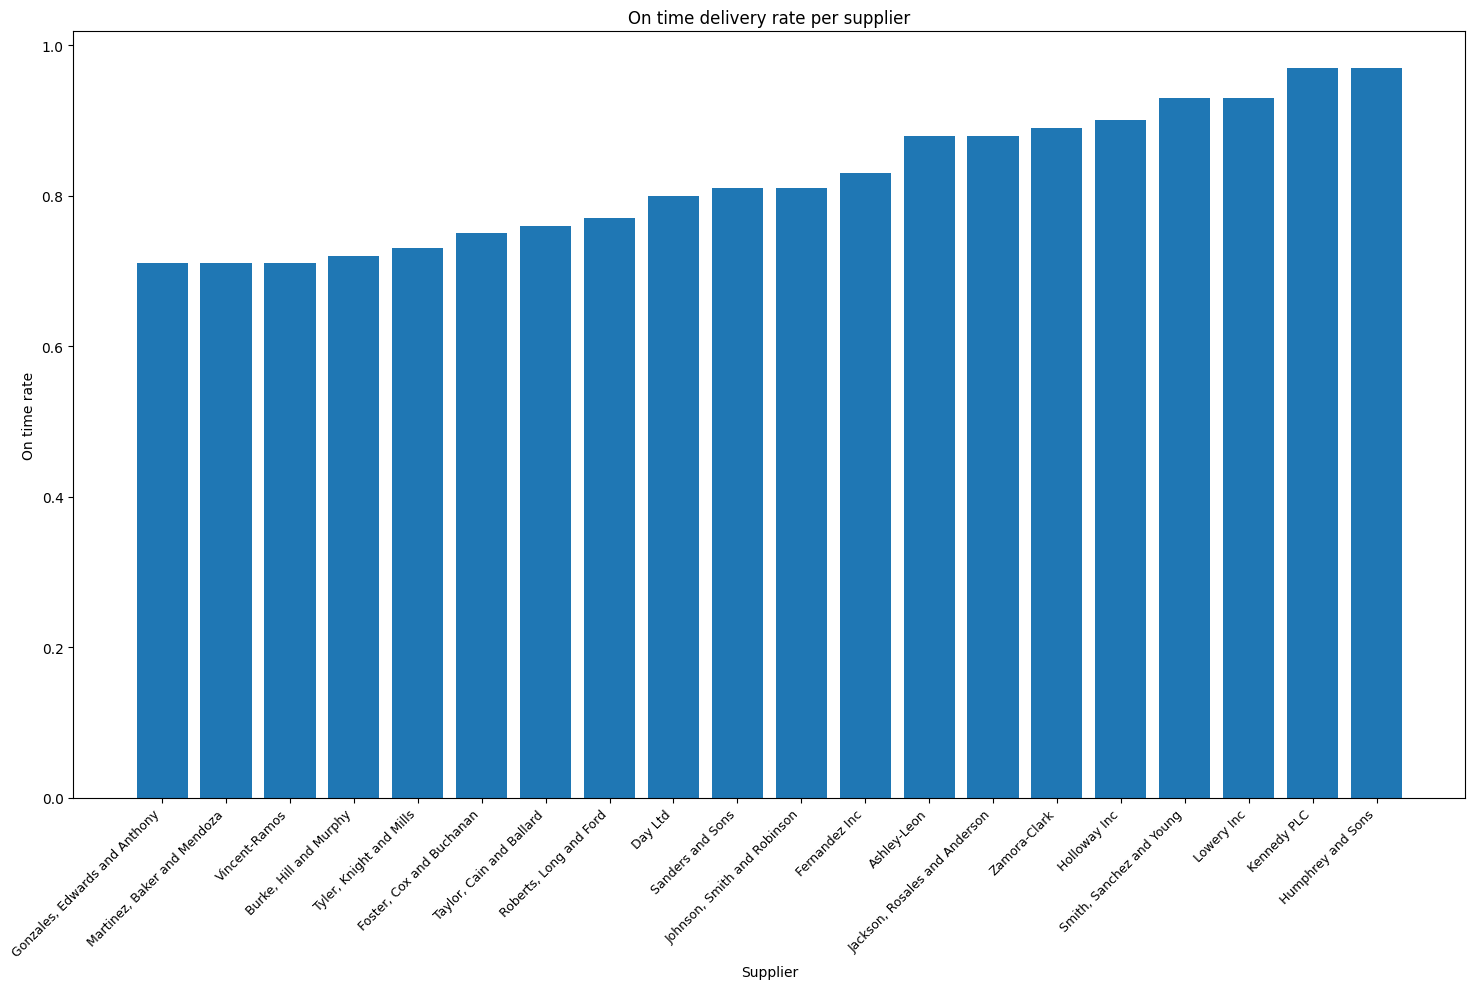

In [64]:
plt.figure(figsize=(15, 10))
plt.bar(dfsuppsorted['supplier_name'], dfsuppsorted['on_time_rate'])

plt.title('On time delivery rate per supplier')

plt.xlabel('Supplier')

plt.ylabel('On time rate')

plt.xticks(rotation=45, horizontalalignment='right', fontsize=9)

plt.tight_layout()
plt.show()


In [65]:
dfsupp['performance'] = pd.cut(
    x=dfsupp['on_time_rate'], 
    bins= [0, 0.8, 0.9, 1], 
    labels= ['Poor', 'Average', 'Excellent'], 
    ordered=True)

In [66]:
dfsupp.head()

,supplier_id,supplier_name,country,lead_time_days,on_time_rate,freight_cost,performance
0,1,"Smith, Sanchez and Young",Tokelau,11,0.93,1494,Excellent
1,2,Lowery Inc,Uruguay,15,0.93,1838,Excellent
2,3,"Tyler, Knight and Mills",Italy,23,0.73,1682,Poor
3,4,Day Ltd,Grenada,28,0.80,330,Poor
4,5,"Burke, Hill and Murphy",Micronesia,26,0.72,2591,Poor
